# CAPPI with wradlib
- @author: [Hamid Ali Syed](https://syedha.com)
- @date: Nov 30, 2022
- @purpose: "For Adithiy Nair"

In [2]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
from datetime import datetime
import pyart
import numpy as np
import wradlib as wrl
import glob, os
warnings.filterwarnings('ignore')

In [3]:
files = sorted(glob.glob("RC*L2B*nc"))
len(files)

7

In [4]:
def CAPPI(file = None, fields = ["DBZ", "VEL", "PHIDP", "ZDR"], save_data=False, path = './'):
    print(f"Reading: {file}")
    new_vol = wrl.io.open_cfradial2_dataset(file)
    # Iterate over sweeps and process
    swp_list = []
    for v in new_vol:
        # georeference and stack dimensions
        swp = v.pipe(wrl.georef.georeference_dataset).stack(points=["azimuth", "range"])
        swp_list.append(swp)

    # concat sweeps to volume
    vol0 = xr.concat(swp_list, dim="points")

    # Create XYZ Coordinate DataArray
    xyz = xr.concat([vol0.x, vol0.y, vol0.z], dim="xyz").transpose()

    # Create Target 3D Grid, choose your wanted resolution
    xcnt = 200
    ycnt = 200
    zcnt = 40
    trgx = np.linspace(xyz[:, 0].min(),xyz[:, 0].max(), xcnt)
    trgy = np.linspace(xyz[:, 1].min(),xyz[:, 1].max(), ycnt)
    trgz = np.linspace(0, 20000, zcnt)
    yy, hh, xx = np.meshgrid(trgy,trgz,trgx)
    trgxyz = np.stack([xx.flatten(), yy.flatten(), hh.flatten()]).T

    # Create Gridder/Interpolator
    trgshape=xx.shape
    gridder = wrl.vpr.CAPPI(polcoords=xyz,
                            gridcoords=trgxyz,
                            gridshape=trgshape,
                            maxrange=vol0.range.values.max(),
                            minelev=0,
                            maxelev=vol0.fixed_angle.values.max(),
                            ipclass=wrl.ipol.Nearest)
    # Interpolate Data into 3D Grid
    trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
    trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
    trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
    latlon = pyart.core.cartesian_to_geographic_aeqd(trgx, trgy, 
                                                     lon_0=vol0.longitude.data, 
                                                     lat_0=vol0.latitude.data)
    lat = latlon[1]
    lon = latlon[0]
    print(f"Converting to grid")
    ds_list = []
    for field in fields:
        varname = np.ma.masked_invalid(gridder(vol0[field].where(vol0.PHIDP<181).values)).reshape(trgshape)
        ds = xr.Dataset(
        data_vars=
        {
            field:(["z", "y", "x"], varname),
        },
        coords={
            "x": (["x"], trgx),
            "y": (["y"], trgy),
            "z": (["z"], trgz),
            "lat":(["y"], lat),
            "lon":(["x"], lon),
            "time":(vol0.time.mean().values)
                },
              )
        ds = ds.expand_dims(dim="time", axis=0)
        ds_list.append(ds)
    new_ds = xr.combine_by_coords(ds_list)
    if save_data:
        print(f"Saving data {file} in {path}")
        os.makedirs(path, exist_ok=True)
        new_ds.to_netcdf(path+"RCTLS_"+str(vol0.time.mean().dt.strftime("%Y%m%d%H%M%S").data)+"_grid.nc")
    return new_ds

In [5]:
files = sorted(glob.glob("R*L2B*.nc"))
files

['RCTLS_30NOV2017_000100_L2B_STD.nc',
 'RCTLS_30NOV2017_001519_L2B_STD.nc',
 'RCTLS_30NOV2017_002937_L2B_STD.nc',
 'RCTLS_30NOV2017_004355_L2B_STD.nc',
 'RCTLS_30NOV2017_005816_L2B_STD.nc',
 'RCTLS_30NOV2017_011235_L2B_STD.nc',
 'RCTLS_30NOV2017_012653_L2B_STD.nc']

In [6]:
for file in files:
    CAPPI(file=file, fields=['DBZ', 'ZDR'], save_data=True, path="./gridded_data/")

Reading: RCTLS_30NOV2017_000100_L2B_STD.nc
Converting to grid
Saving data RCTLS_30NOV2017_000100_L2B_STD.nc in ./gridded_data/
Reading: RCTLS_30NOV2017_001519_L2B_STD.nc
Converting to grid
Saving data RCTLS_30NOV2017_001519_L2B_STD.nc in ./gridded_data/
Reading: RCTLS_30NOV2017_002937_L2B_STD.nc
Converting to grid
Saving data RCTLS_30NOV2017_002937_L2B_STD.nc in ./gridded_data/
Reading: RCTLS_30NOV2017_004355_L2B_STD.nc
Converting to grid
Saving data RCTLS_30NOV2017_004355_L2B_STD.nc in ./gridded_data/
Reading: RCTLS_30NOV2017_005816_L2B_STD.nc
Converting to grid
Saving data RCTLS_30NOV2017_005816_L2B_STD.nc in ./gridded_data/
Reading: RCTLS_30NOV2017_011235_L2B_STD.nc
Converting to grid
Saving data RCTLS_30NOV2017_011235_L2B_STD.nc in ./gridded_data/
Reading: RCTLS_30NOV2017_012653_L2B_STD.nc
Converting to grid
Saving data RCTLS_30NOV2017_012653_L2B_STD.nc in ./gridded_data/


In [7]:
!ls gridded_data/RC*

gridded_data/RCTLS_20171130000420_grid.nc
gridded_data/RCTLS_20171130001839_grid.nc
gridded_data/RCTLS_20171130003257_grid.nc
gridded_data/RCTLS_20171130004715_grid.nc
gridded_data/RCTLS_20171130010136_grid.nc
gridded_data/RCTLS_20171130011555_grid.nc
gridded_data/RCTLS_20171130013013_grid.nc


In [8]:
grids = xr.open_mfdataset("gridded_data/*nc")

In [9]:
grids.DBZ

<xarray.DataArray 'DBZ' (time: 7, z: 40, y: 200, x: 200)>
dask.array<concatenate, shape=(7, 40, 200, 200), dtype=float64, chunksize=(1, 40, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -2.398e+05 -2.374e+05 -2.35e+05 ... 2.374e+05 2.398e+05
  * y        (y) float64 -2.398e+05 -2.374e+05 -2.35e+05 ... 2.374e+05 2.398e+05
  * z        (z) float64 0.0 384.6 769.2 ... 1.423e+04 1.462e+04 1.5e+04
    lat      (y) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2017-11-30T00:04:20 ... 2017-11-30T01:30:13

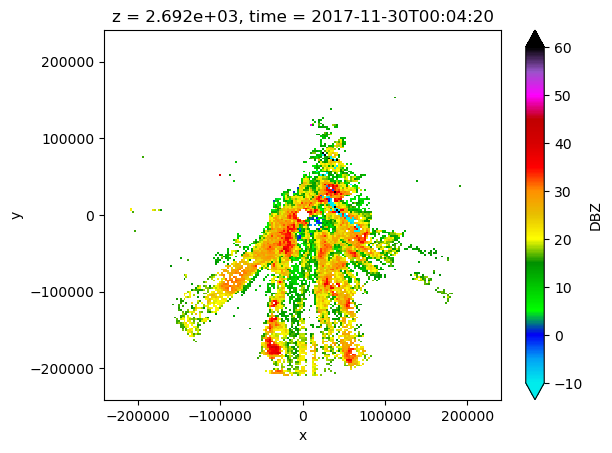

In [10]:
grids["DBZ"][0].sel(z = 2500, method = "nearest").plot(vmin = -10, vmax = 60, cmap = "pyart_NWSRef")

(0.0, 15000.0)

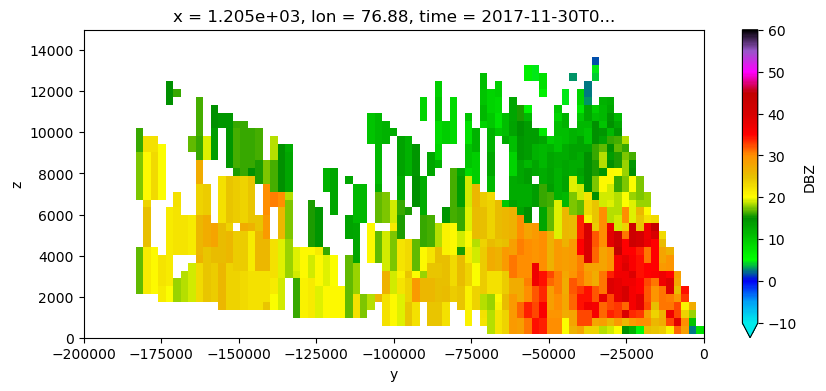

In [11]:
grids['DBZ'][6].sel(x = 0, method="nearest").plot(vmin = -10, vmax = 60, cmap = "pyart_NWSRef", figsize = [10, 4])
plt.xlim(-20e4, 0)
plt.ylim(0, 15e3)

(0.0, 13000.0)

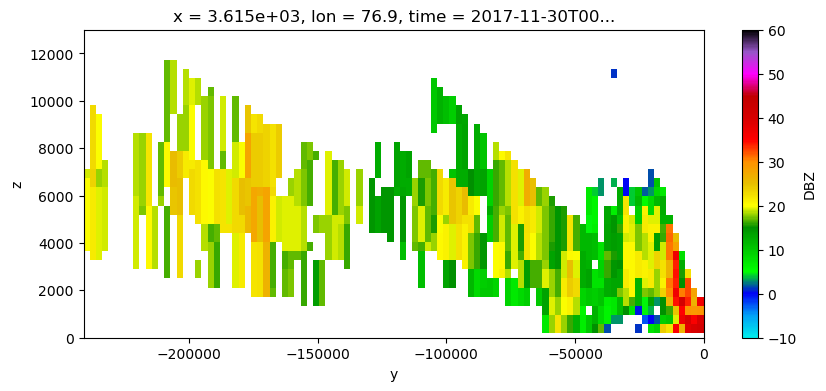

In [12]:
grids["DBZ"][0].sel(x = 4000, method="nearest").plot(vmin = -10, vmax = 60, cmap = "pyart_NWSRef", figsize = [10, 4])
plt.xlim(None, 0)
plt.ylim(0, 13e3)

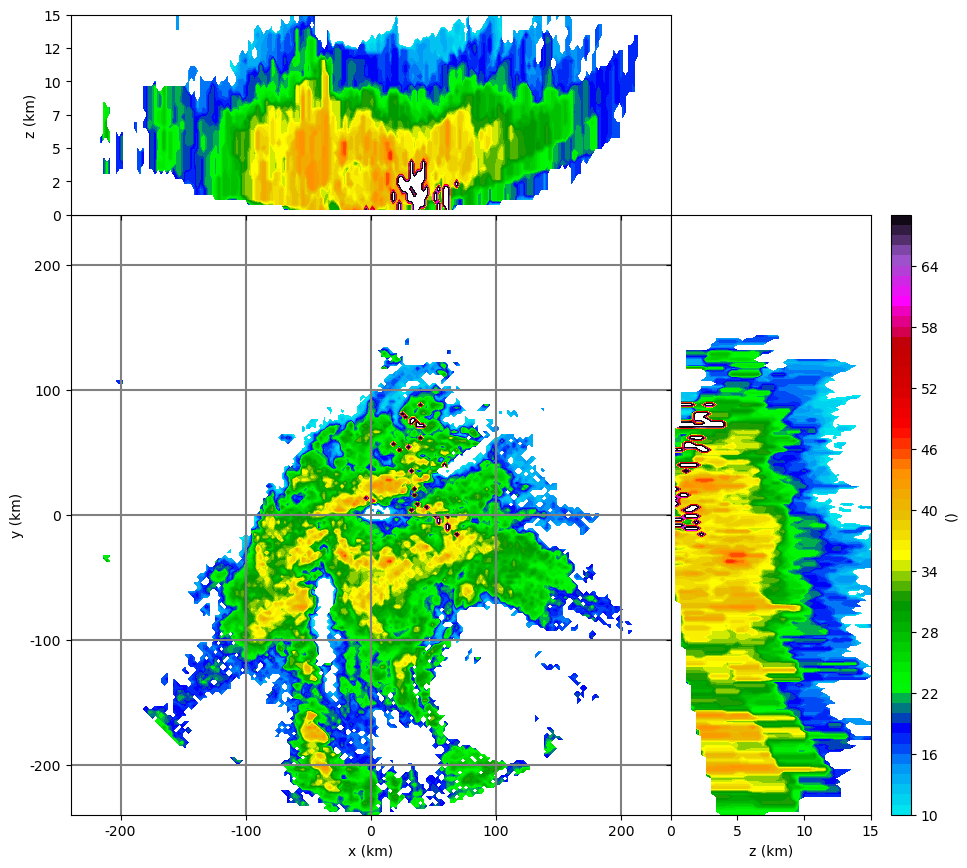

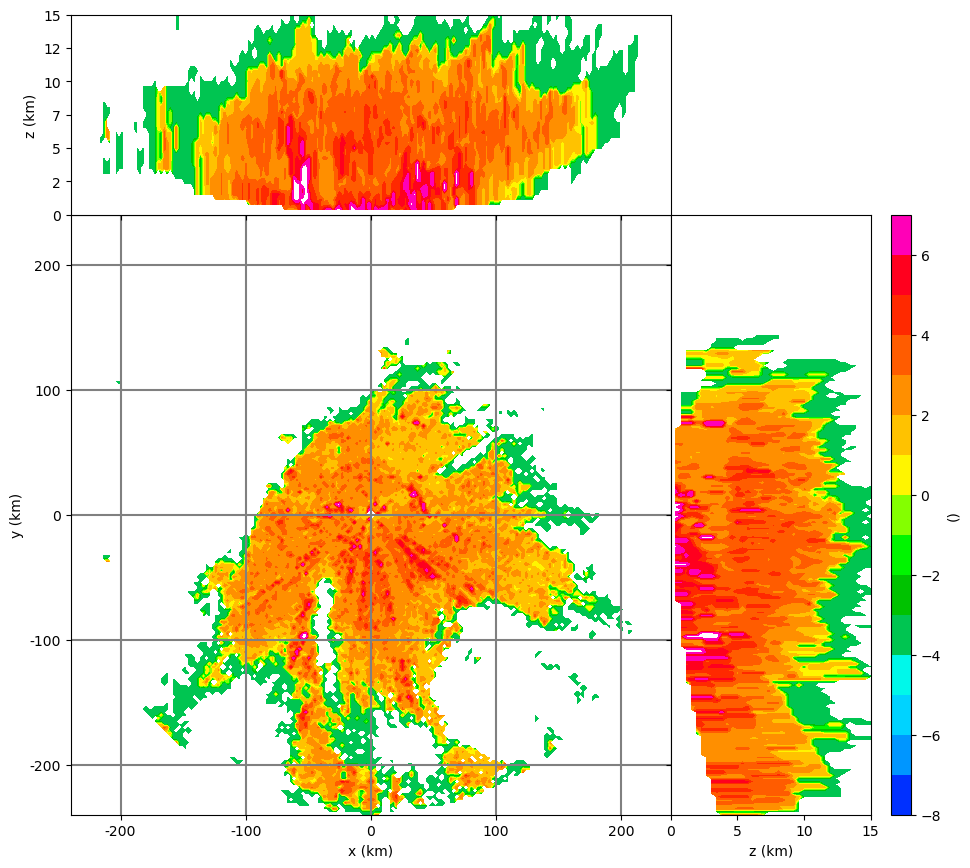

In [13]:
wrl.vis.plot_max_plan_and_vert(grids.x, grids.y, grids.z, grids.DBZ[3], cmap = "pyart_NWSRef", levels=range(10, 70, 1))
wrl.vis.plot_max_plan_and_vert(grids.x, grids.y, grids.z, grids.ZDR[3], cmap = pyart.graph.cm.RefDiff, levels=range(-8, 8, 1))

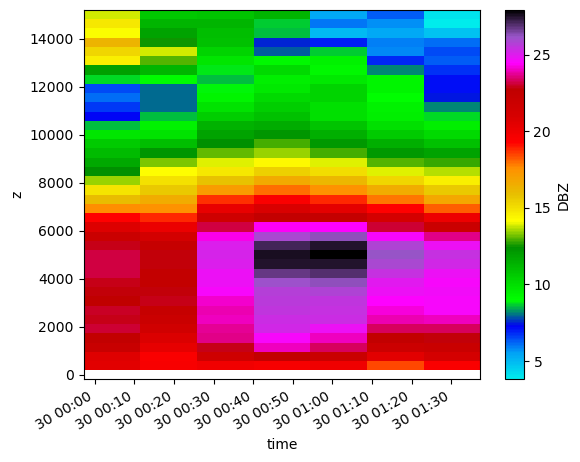

In [15]:
grids.sel(x = slice(-100000, 0), y=slice(-100000, 0)).mean(['x','y'])["DBZ"].plot(x = "time", cmap = "pyart_NWSRef")